In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from itertools import combinations
import scipy.stats as stats
from itertools import combinations
import lightgbm as lgbm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
df = pd.read_csv('/kaggle/input/income-classification/income_evaluation.csv')

### 1) Veriyi Tanıma ve Genel Temizleme

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              32561 non-null  int64 
 1    workclass       32561 non-null  object
 2    fnlwgt          32561 non-null  int64 
 3    education       32561 non-null  object
 4    education-num   32561 non-null  int64 
 5    marital-status  32561 non-null  object
 6    occupation      32561 non-null  object
 7    relationship    32561 non-null  object
 8    race            32561 non-null  object
 9    sex             32561 non-null  object
 10   capital-gain    32561 non-null  int64 
 11   capital-loss    32561 non-null  int64 
 12   hours-per-week  32561 non-null  int64 
 13   native-country  32561 non-null  object
 14   income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [4]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [5]:
df.shape

(32561, 15)

In [6]:
df = df.rename(columns = {' workclass':'workclass',' fnlwgt':'fnlwgt',' education':'education',' education-num':'education-num',' marital-status':'marital-status',' occupation':'occupation',' relationship':'relationship',' race':'race',' sex':'sex',' capital-gain':'capital-gain',' capital-loss':'capital-loss',' hours-per-week':'hours-per-week',' native-country':'country',' income':'income'})

In [7]:
#education'ı zaten sıralama ölçme düzeyine göre başka bir sütunda verdiği için siliyorum
df = df.drop('education',axis = 1)

In [8]:
#Önce united-states dışında yaşayan satırları silip feature'u kaldırıcam
print(df['income'].value_counts().sort_values())
df['country'].value_counts()
df = df[df['country'] == ' United-States']
print(df['income'].value_counts().sort_values())
df = df.drop('country',axis = 1)
df.shape

income
>50K      7841
<=50K    24720
Name: count, dtype: int64
income
>50K      7171
<=50K    21999
Name: count, dtype: int64


(29170, 13)

In [9]:
df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

In [10]:
#Yalnızca 2 farklı değer içerdiğinden 0-1 olarak numaralandırıcam 
print(df['sex'].value_counts())
print(df['income'].value_counts())
df['sex'] = df['sex'].apply(lambda x: '1' if x == 'Male' else '0')
df['income'] = df['income'].apply(lambda x: '0' if x == '<=50K' else '1')
print(df['sex'].value_counts())
print(df['income'].value_counts())

sex
Male      19488
Female     9682
Name: count, dtype: int64
income
<=50K    21999
>50K      7171
Name: count, dtype: int64
sex
1    19488
0     9682
Name: count, dtype: int64
income
0    21999
1     7171
Name: count, dtype: int64


### 1-a) Kategorik verileri inceleme

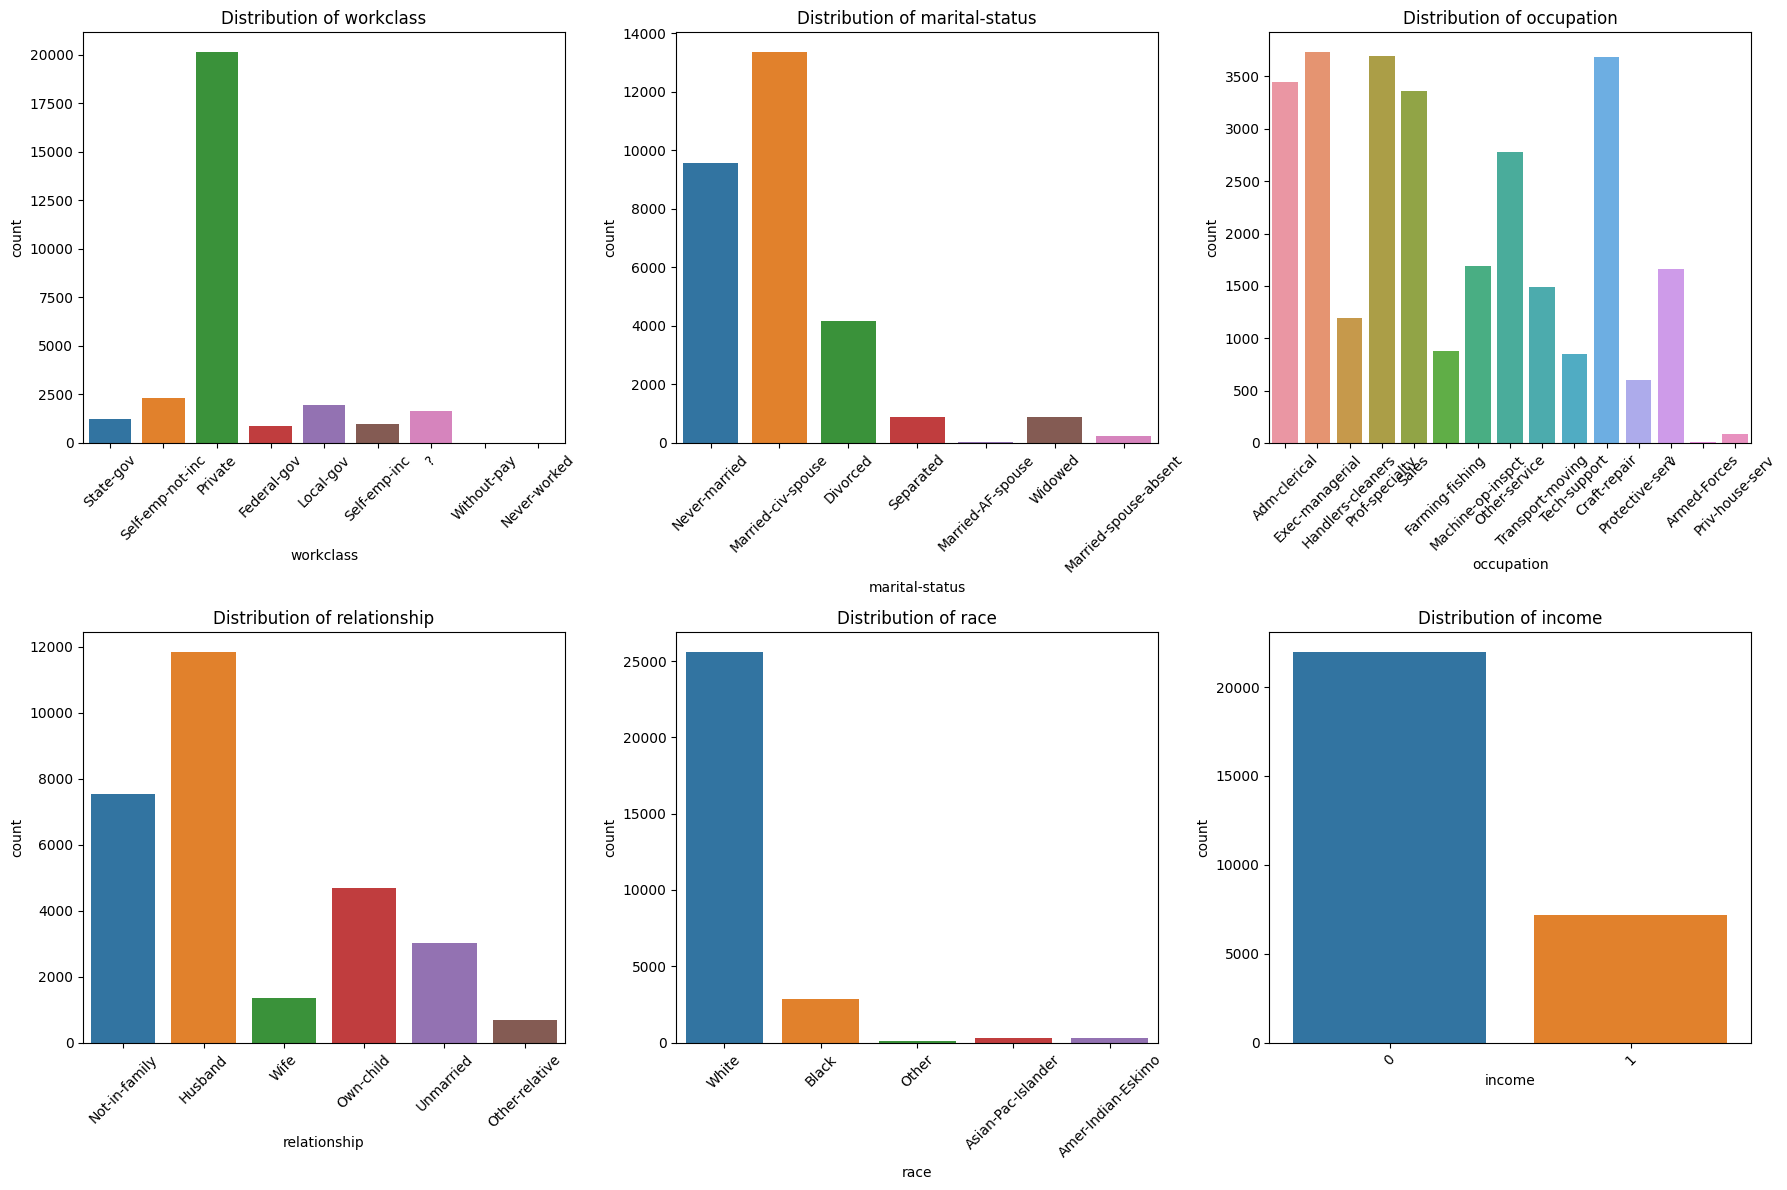

In [11]:
categorical_columns = ['workclass','marital-status','occupation','relationship','race','income']

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))

for i, col in enumerate(categorical_columns):
    sns.countplot(data=df, x=col, ax=axs[i//3, i%3])
    axs[i//3, i%3].set_title(f'Distribution of {col}')
    axs[i//3, i%3].tick_params(axis='x', rotation=45)

for j in range(i+1, 6):
    fig.delaxes(axs[j//3, j%3])

plt.tight_layout()
plt.show()

### workclass inceleme

In [12]:
print(pd.crosstab(df['workclass'], df['income'], normalize='index'),'\n')
df['workclass'] = df['workclass'].replace(['Without-pay','Never-worked'],'Never-worked')
df['workclass'] = df['workclass'].replace(['Local-gov','Self-emp-not-inc','State-gov'],'State-gov,local-gov,self-emp-not-inc')
print(pd.crosstab(df['workclass'], df['income'], normalize='index'))
#Targeta etkisi çok yakın olanları aynı aktegoride birleştirdim

income                   0         1
workclass                           
?                 0.893912  0.106088
Federal-gov       0.620767  0.379233
Local-gov         0.706033  0.293967
Never-worked      1.000000  0.000000
Private           0.774472  0.225528
Self-emp-inc      0.436932  0.563068
Self-emp-not-inc  0.715089  0.284911
State-gov         0.730579  0.269421
Without-pay       1.000000  0.000000 

income                                       0         1
workclass                                               
?                                     0.893912  0.106088
Federal-gov                           0.620767  0.379233
Never-worked                          1.000000  0.000000
Private                               0.774472  0.225528
Self-emp-inc                          0.436932  0.563068
State-gov,local-gov,self-emp-not-inc  0.715277  0.284723


### marital-status inceleme

In [13]:
print(pd.crosstab(df['marital-status'], df['income'], normalize='index'),'\n')
df['marital-status'] = df['marital-status'].replace(['Divorced','Married-spouse-absent','Never-married','Separated','Widowed'],'Single')
df['marital-status'] = df['marital-status'].replace(['Married-AF-spouse','Married-civ-spouse'],'Married')
print(pd.crosstab(df['marital-status'], df['income'], normalize='index'))
#Targeta etkisi çok yakın olanları aynı aktegoride birleştirdim

income                        0         1
marital-status                           
Divorced               0.895483  0.104517
Married-AF-spouse      0.565217  0.434783
Married-civ-spouse     0.542415  0.457585
Married-spouse-absent  0.897233  0.102767
Never-married          0.953231  0.046769
Separated              0.932050  0.067950
Widowed                0.916851  0.083149 

income                 0         1
marital-status                    
Married         0.542454  0.457546
Single          0.933836  0.066164


### occupation inceleme

In [14]:
print(pd.crosstab(df['occupation'], df['income'], normalize='index'),'\n')
df['occupation'] = df['occupation'].replace(['?','Adm-clerical','Armed-Forces','Machine-op-inspct','Farming-fishing'],'Adm-clerical,Armed-Forces,Machine-op-inspct,?,Farming-fishing')
df['occupation'] = df['occupation'].replace(['Other-service','Priv-house-serv','Handlers-cleaners'],'Other-service,cleaners')
df['occupation'] = df['occupation'].replace(['Tech-support','Protective-serv'],'Tech-support,Protective-serv')
df['occupation'] = df['occupation'].replace(['Craft-repair','Transport-moving'],'Craft-repair,Transport-moving')
print(pd.crosstab(df['occupation'], df['income'], normalize='index'))
#Targeta etkisi çok yakın olanları aynı aktegoride birleştirdim

income                    0         1
occupation                           
?                  0.894358  0.105642
Adm-clerical       0.867208  0.132792
Armed-Forces       0.888889  0.111111
Craft-repair       0.766621  0.233379
Exec-managerial    0.513253  0.486747
Farming-fishing    0.873720  0.126280
Handlers-cleaners  0.938604  0.061396
Machine-op-inspct  0.867220  0.132780
Other-service      0.961829  0.038171
Priv-house-serv    0.988889  0.011111
Prof-specialty     0.553209  0.446791
Protective-serv    0.665017  0.334983
Sales              0.724138  0.275862
Tech-support       0.697647  0.302353
Transport-moving   0.795439  0.204561 

income                                                     0         1
occupation                                                            
Adm-clerical,Armed-Forces,Machine-op-inspct,?,F...  0.873862  0.126138
Craft-repair,Transport-moving                       0.774923  0.225077
Exec-managerial                                     0.513253  0.4867

### relationship inceleme

In [15]:
print(pd.crosstab(df['relationship'], df['income'], normalize='index'),'\n')
df['relationship'] = df['relationship'].replace(['Husband','Wife'],'Wife,husband')
df['relationship'] = df['relationship'].replace(['Not-in-family','Other-relative','Own-child','Unmarried'],'Unmarried')
print(pd.crosstab(df['relationship'], df['income'], normalize='index'))
#Targeta etkisi çok yakın olanları aynı aktegoride birleştirdim

income                 0         1
relationship                      
Husband         0.542619  0.457381
Not-in-family   0.894660  0.105340
Other-relative  0.961207  0.038793
Own-child       0.987423  0.012577
Unmarried       0.935378  0.064622
Wife            0.506980  0.493020 

income               0         1
relationship                    
Unmarried     0.932593  0.067407
Wife,husband  0.538950  0.461050


### race inceleme

In [16]:
print(pd.crosstab(df['race'], df['income'], normalize='index'),'\n')
print(df['race'].value_counts())
#race de hem white çok fazla bir yığılma olması iyi değil hemde bütün ırkların gelir düzeyi çok yakın bu yüzden targetı çok etkilemiyor olabilir

income                     0         1
race                                  
Amer-Indian-Eskimo  0.881757  0.118243
Asian-Pac-Islander  0.767123  0.232877
Black               0.876059  0.123941
Other               0.899225  0.100775
White               0.738340  0.261660 

race
White                 25621
Black                  2832
Amer-Indian-Eskimo      296
Asian-Pac-Islander      292
Other                   129
Name: count, dtype: int64


### sex inceleme

In [17]:
print(pd.crosstab(df['sex'], df['income'], normalize='index'),'\n')
#cinsiyetler arası çok fark yok çıkartılabilir

income         0         1
sex                       
0       0.889279  0.110721
1       0.687038  0.312962 



### 1-b,Numerik verileri inceleme

In [18]:
df.head()

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,income
0,39,"State-gov,local-gov,self-emp-not-inc",77516,13,Single,"Adm-clerical,Armed-Forces,Machine-op-inspct,?,...",Unmarried,White,1,2174,0,40,0
1,50,"State-gov,local-gov,self-emp-not-inc",83311,13,Married,Exec-managerial,"Wife,husband",White,1,0,0,13,0
2,38,Private,215646,9,Single,"Other-service,cleaners",Unmarried,White,1,0,0,40,0
3,53,Private,234721,7,Married,"Other-service,cleaners","Wife,husband",Black,1,0,0,40,0
5,37,Private,284582,14,Married,Exec-managerial,"Wife,husband",White,0,0,0,40,0


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

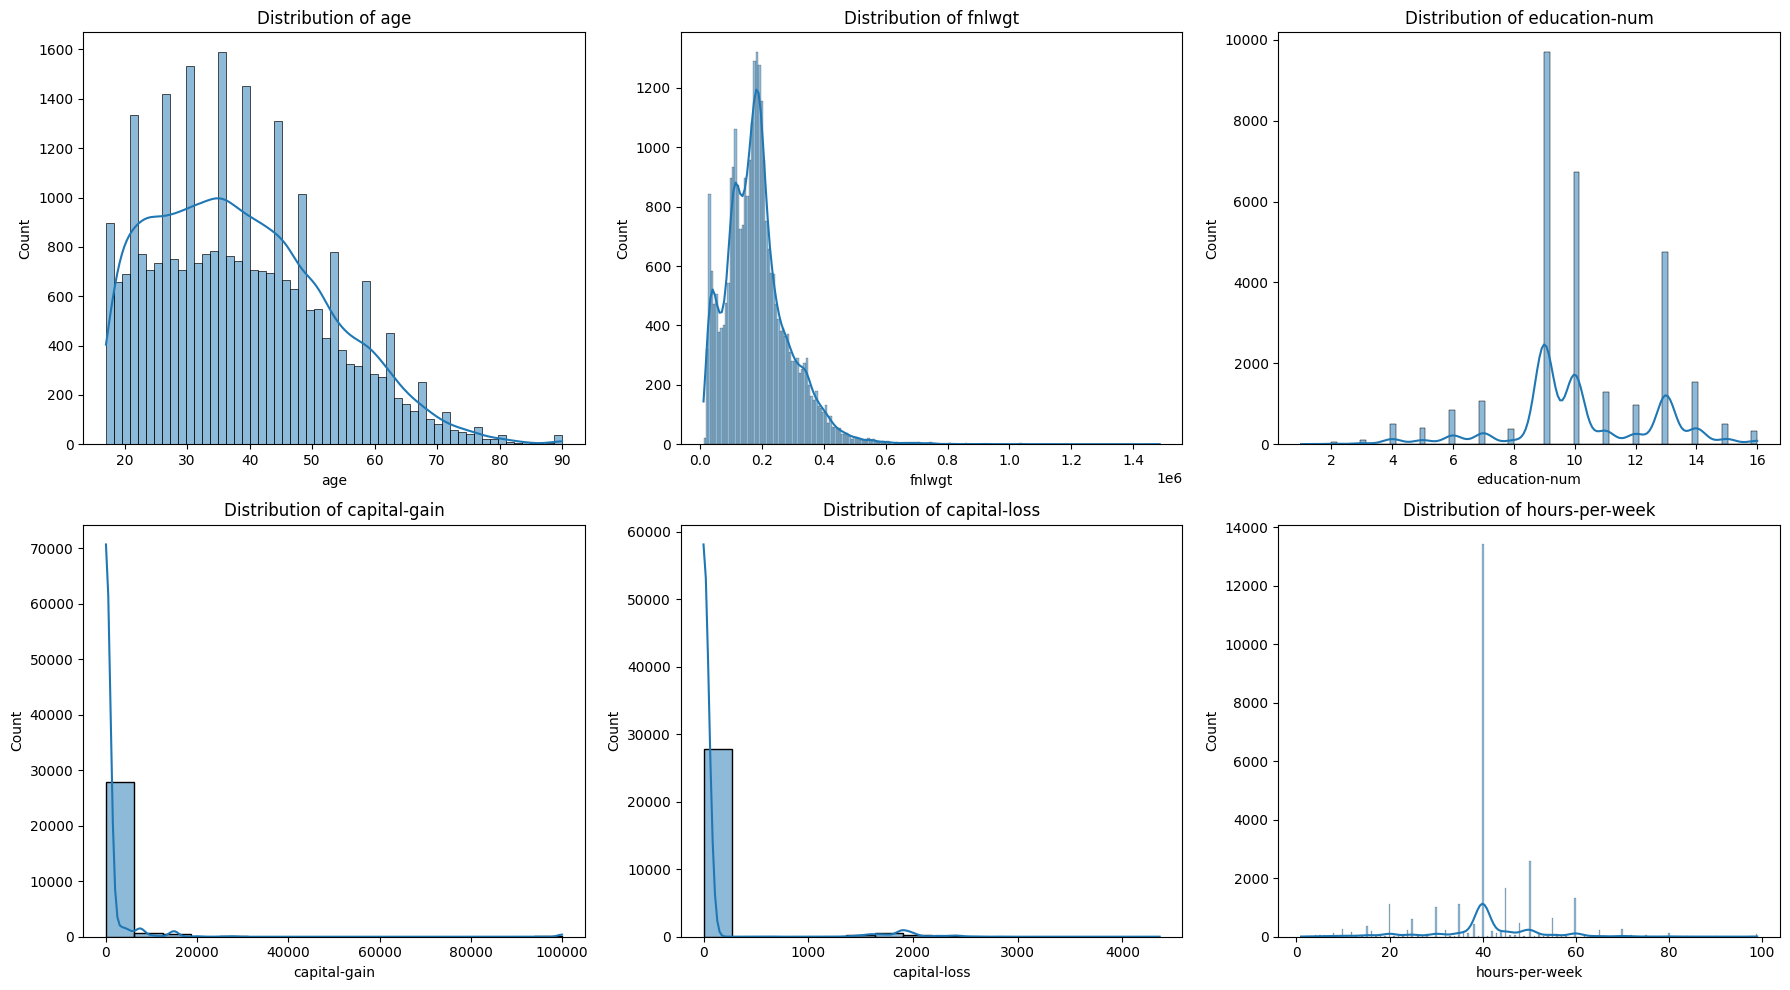

In [19]:
numeric_columns = ['age','fnlwgt','education-num','capital-gain','capital-loss','hours-per-week']

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))

for i, col in enumerate(numeric_columns):
    sns.histplot(df[col], kde=True, ax=axs[i//3, i%3])
    axs[i//3, i%3].set_title(f'Distribution of {col}')

# Kalan boş subplotları kaldır
for j in range(i+1, 6):
    fig.delaxes(axs[j//3, j%3])

plt.tight_layout()
plt.show()

In [20]:
df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,29170.000000,2.917000e+04,29170.000000,29170.000000,29170.000000,29170.000000
mean,38.655674,1.870690e+05,10.169455,1089.229928,88.510593,40.447755
std,13.722408,1.048780e+05,2.394966,7381.898528,405.681709,12.417203
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.158952e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.767300e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.341385e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [21]:
print(df.shape)
print(len(df[df['capital-gain']==0]))
print(len(df[df['capital-loss']==0]))

(29170, 13)
26699
27791


### 2) Targetla Kategorik Featurelar Arasında Korelasyon (Cramer V)

In [22]:
#Targetla diğer kategorikler arasında Cramerin V'si katsayısına baktım
kategorik_features = ['workclass','marital-status','occupation','relationship','race','sex']
def cramers_v(chi2, n, k):
        return np.sqrt(chi2 / (n * (k - 1)))
for i in kategorik_features:
    contingency_table = pd.crosstab(df['income'], df[i])

    chi2_stat, p_val, dof, ex = chi2_contingency(contingency_table)
    print(f"İncome and {i} P-Value: {p_val}")

    n = contingency_table.sum().sum() 
    k = min(contingency_table.shape)  

    cramers_v_value = cramers_v(chi2_stat, n, k)
    print(f"İncome and {i} Cramér's V: {cramers_v_value}\n")
# P-degeri ne kadar anlamlı olsada 0.1 düşük bir değer olduğu için race'yi atabilirim

İncome and workclass P-Value: 6.110703526629077e-191
İncome and workclass Cramér's V: 0.17503723813525318

İncome and marital-status P-Value: 0.0
İncome and marital-status Cramér's V: 0.4528761063109948

İncome and occupation P-Value: 0.0
İncome and occupation Cramér's V: 0.3475140696571395

İncome and relationship P-Value: 0.0
İncome and relationship Cramér's V: 0.4550266034529174

İncome and race P-Value: 3.181960800470026e-64
İncome and race Cramér's V: 0.10182879114477839

İncome and sex P-Value: 0.0
İncome and sex Cramér's V: 0.2210944303369063



### 3) Targetla Numerik Featurelar Arasındaki Korelasyon (ETA)

In [23]:
#Target ile Numeric featurelar arasında Eta katsayısına baktım
numerics = ['age','fnlwgt','education-num','capital-gain', 'capital-loss', 'hours-per-week']

for i in numerics:
    
    numeric_ort = df[i].mean()
    toplam = 0
    for j in df[i]:
        toplam += (j-numeric_ort)**2
    top_varyans = toplam / (len(df[i])-1)

    grup_ort = df.groupby('income')[i].mean()
    toplam2 = 0
    for isim,ort in grup_ort.items():
        kategorik_adedi = len(df[df['income'] == isim])
        toplam2 += ((ort-numeric_ort)**2)*kategorik_adedi
    gruplar_varyans = toplam2/((len(df)-len(grup_ort)))
    print(f'income & {i} : {(gruplar_varyans/top_varyans)**0.5}')
#fnlwgt ile ilişkisi çok düşük muhtemelen çıkartıcam

income & age : 0.23472924024376976
income & fnlwgt : 0.0019869069493016946
income & education-num : 0.33600018402337434
income & capital-gain : 0.22260483258568556
income & capital-loss : 0.14912062917664398
income & hours-per-week : 0.23255473747812844


### 4) Kategorik Featureların Kendi Aralarındaki İlişki (Cramer V)

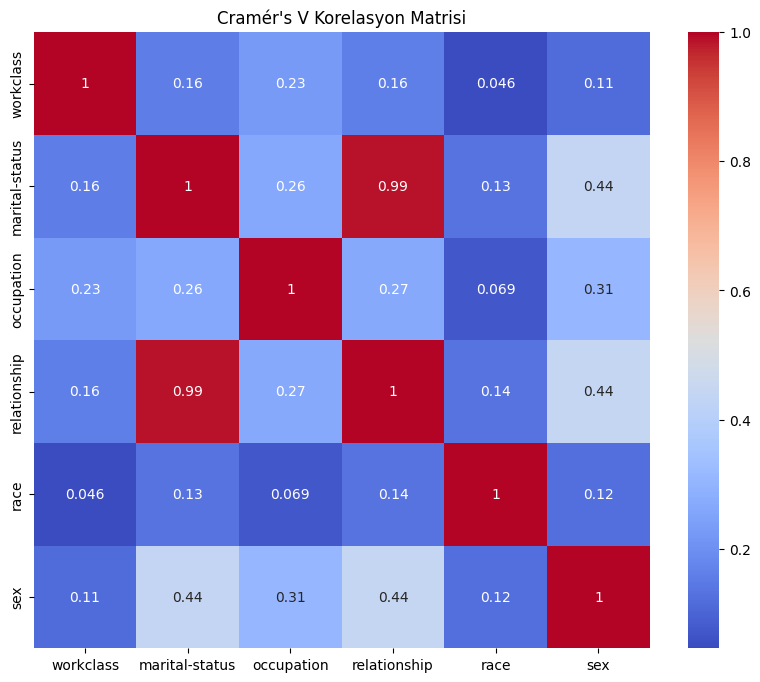

In [24]:
kategorik_features = ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex']
cramers_v_matrix = pd.DataFrame(index=kategorik_features, columns=kategorik_features)

for feature1, feature2 in combinations(kategorik_features, 2):
    contingency_table = pd.crosstab(df[feature1], df[feature2])

    chi2_stat, p_val, dof, ex = chi2_contingency(contingency_table)

    n = contingency_table.sum().sum()
    k = min(contingency_table.shape)

    cramers_v_value = cramers_v(chi2_stat, n, k)
    
    cramers_v_matrix.at[feature1, feature2] = cramers_v_value
    cramers_v_matrix.at[feature2, feature1] = cramers_v_value

np.fill_diagonal(cramers_v_matrix.values, 1.0)

plt.figure(figsize=(10, 8))
sns.heatmap(cramers_v_matrix.astype(float), annot=True, cmap="coolwarm", cbar=True, square=True)
plt.title("Cramér's V Korelasyon Matrisi")
plt.show()
#Sex ile hem relationship hem occupation hem marital-status arasında çok anlamlı bir ilişki var targetlada ilişkisi diğer 3 ünden daha az
#Bu yüzden sex sütununu çıkartıcam
#marital-status ile relationship'inde çok ciddi ilişkisi var 2 sininide targetla korelasyonu eşit ben relationshipi atma kararı aldım

### 5) Numerik Featureların Kendi Aralarındaki İlişki

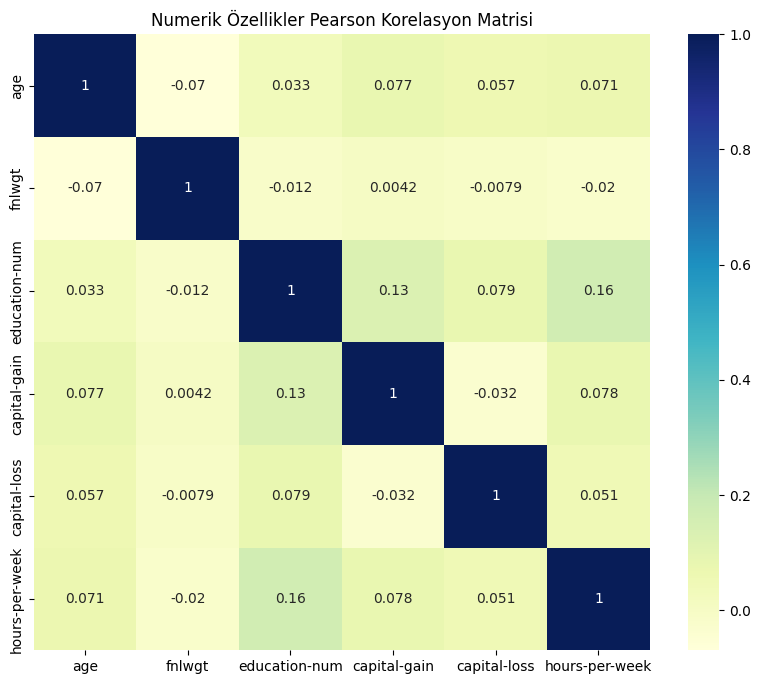

In [25]:
numerics = ['age','fnlwgt','education-num','capital-gain', 'capital-loss', 'hours-per-week']
pearson_corr_matrix = df[numerics].corr(method='pearson')

plt.figure(figsize=(10, 8))
sns.heatmap(pearson_corr_matrix, annot=True, cmap="YlGnBu", cbar=True, square=True)
plt.title("Numerik Özellikler Pearson Korelasyon Matrisi")
plt.show()
#Herhangi bi çoklu bağlantı yok

### 6) Kategorik featurelar ile numerik featureların arasındaki ilişki (ETA)

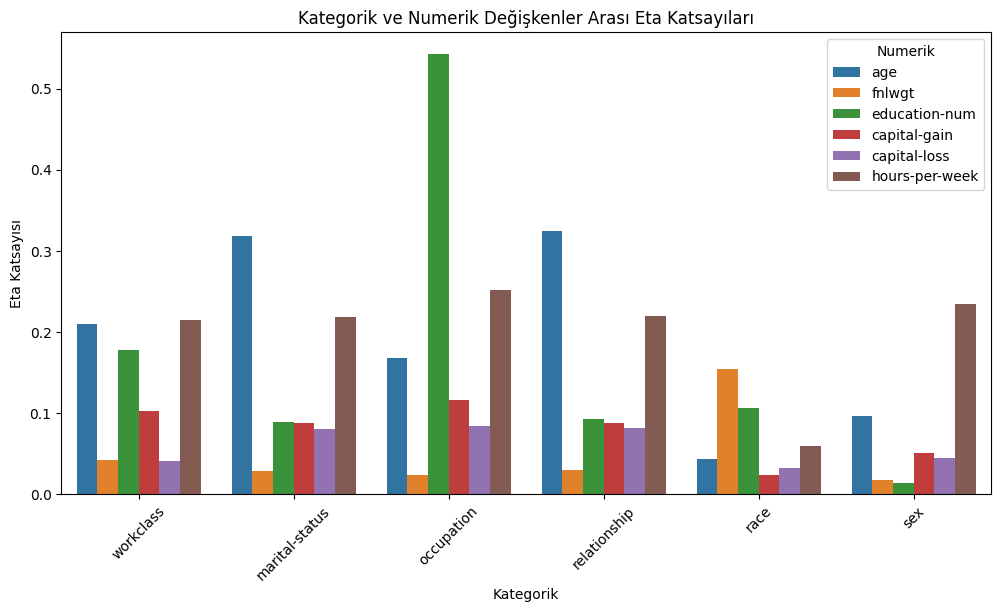

In [26]:
numerics = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
kategorik_features = ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex']

eta_results = []

for kategorik in kategorik_features:
    for numerik in numerics:
        numeric_ort = df[numerik].mean()
        
        toplam = sum((df[numerik] - numeric_ort) ** 2)
        top_varyans = toplam / (len(df[numerik]) - 1)
        
        grup_ort = df.groupby(kategorik)[numerik].mean()
        toplam2 = 0
        
        for isim, ort in grup_ort.items():
            kategorik_adedi = len(df[df[kategorik] == isim])
            toplam2 += ((ort - numeric_ort) ** 2) * kategorik_adedi
            
        gruplar_varyans = toplam2 / (len(df) - len(grup_ort))
        
        eta_katsayisi = (gruplar_varyans / top_varyans) ** 0.5
        
        eta_results.append({'Kategorik': kategorik, 'Numerik': numerik, 'Eta Katsayısı': eta_katsayisi})

eta_df = pd.DataFrame(eta_results)
plt.figure(figsize = (12,6))
sns.barplot(data = eta_df,x = 'Kategorik',y = 'Eta Katsayısı',hue = 'Numerik')
plt.title('Kategorik ve Numerik Değişkenler Arası Eta Katsayıları')
plt.xticks(rotation = 45)
plt.show()
#occupation ile education-num arasında yaklaşık 0.55 lik bir ilişki var ama görmezden gelinebilir çok yüksek değil

In [27]:
df['capital'] = df['capital-gain'] - df['capital-loss']
print(len(df[df['capital']==0]))
numeric_ort = df['capital'].mean()
toplam = 0
for j in df['capital']:
    toplam += (j-numeric_ort)**2
top_varyans = toplam / (len(df['capital'])-1)

grup_ort = df.groupby('income')['capital'].mean()
toplam2 = 0
for isim,ort in grup_ort.items():
    kategorik_adedi = len(df[df['income'] == isim])
    toplam2 += ((ort-numeric_ort)**2)*kategorik_adedi
gruplar_varyans = toplam2/((len(df)-len(grup_ort)))
print(f'income & capital : {(gruplar_varyans/top_varyans)**0.5}')
df = df.drop(['capital-gain','capital-loss'],axis = 1)
#capital-gain ve capital-loss'u tek sütunda birleştirdim bu yüzden onları sildim

25320
income & capital : 0.2137100293563293


In [28]:
#fnlwgt target'ı çok az etkiliyor 
#relationship ile marital status arasındaki korelasyon çok yüksek
df = df.drop(['fnlwgt','relationship','capital'],axis = 1)

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29170 entries, 0 to 32560
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             29170 non-null  int64 
 1   workclass       29170 non-null  object
 2   education-num   29170 non-null  int64 
 3   marital-status  29170 non-null  object
 4   occupation      29170 non-null  object
 5   race            29170 non-null  object
 6   sex             29170 non-null  object
 7   hours-per-week  29170 non-null  int64 
 8   income          29170 non-null  object
dtypes: int64(3), object(6)
memory usage: 2.2+ MB


In [30]:
df = pd.get_dummies(df,columns = ['workclass','marital-status','occupation','race','sex'],drop_first = True)
df = df.astype(int)

In [31]:
print(df.shape)

numerics = ['age','education-num', 'hours-per-week']
for i in numerics:
    q1 = df[i].quantile(0.25)
    q3 = df[i].quantile(0.75)
    iqr = q3-q1
    alt_sınır = q1 - 1.5*iqr
    üst_sınır = q3 + 1.5*iqr

    df = df[(df[i] < üst_sınır) & (df[i] > alt_sınır)]
    print(df.shape)

(29170, 21)
(29023, 21)
(28388, 21)
(20536, 21)


In [32]:
class_0_indices = df[df['income'] == 0].index

np.random.seed(0)
sample_size = int(0.3 * len(class_0_indices))
drop_indices = np.random.choice(class_0_indices, sample_size, replace=False)
df = df.drop(drop_indices)
#Bunu yapmadan önce önce aykırı değer incelemesi yapman lazım
#kategorikler için uç değerler olmadığı aşikar olduğundan sayısal değerler için yapıp saplayabilirsin



x = df.drop('income',axis = 1)
y = df['income']
smote = SMOTE(sampling_strategy = {1:12000},random_state = 0)
x,y = smote.fit_resample(x,y)

x.columns = x.columns.str.replace('[^A-Za-z0-9_]+', '', regex=True)
x_train,x_test,y_train,y_test = train_test_split(x,y,train_size = 0.7,random_state = 0)

In [33]:
class_weight = {0:1,1:4}  
model = lgbm.LGBMClassifier(boosting_type = 'gbdt',class_weight = 'balanced',num_leaves = 30,learning_rate = 0.1,n_estimators = 30, random_state = 0)
model.fit(x_train,y_train,eval_set = [(x_test,y_test)],eval_metric = 'logloss')
y_pred = model.predict(x_test)
print(classification_report(y_test,y_pred))
y_pred2 = model.predict(x_train)
print(classification_report(y_train,y_pred2))

#f1-score direkt olarak 0 sınıfının ve 1 sınıfının sayısına göre değişkenlik gösteriyor

[LightGBM] [Info] Number of positive: 8408, number of negative: 7382
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004163 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 128
[LightGBM] [Info] Number of data points in the train set: 15790, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
              precision    recall  f1-score   support

           0       0.83      0.78      0.80      3176
           1       0.81      0.86      0.84      3592

    accuracy                           0.82      6768
   macro avg       0.82      0.82      0.82      6768
weighted avg       0.82      0.82      0.82      6768

              precision    recall  f1-score   support

           0       0.85      0.78      0.81      7382
         

In [34]:
print(len(y[y == 0]))
print(len(y[y == 1]))

10558
12000


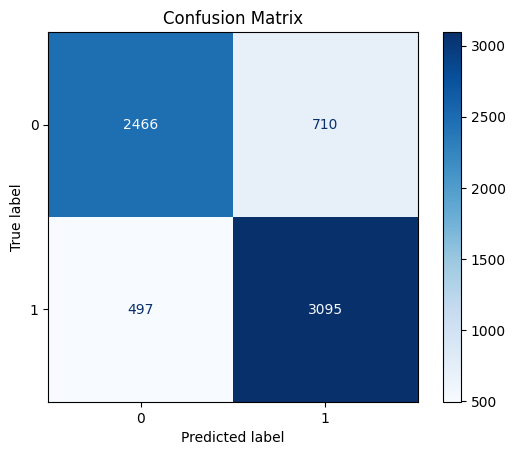

In [35]:
cm = confusion_matrix(y_test,y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels = model.classes_)
cmd.plot(cmap = 'Blues')
plt.title('Confusion Matrix')
plt.show()

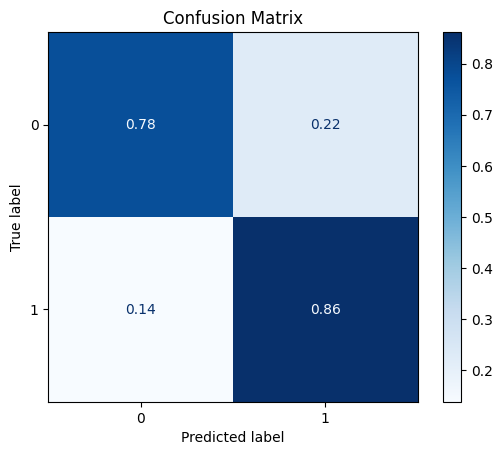

In [36]:
cm = confusion_matrix(y_test,y_pred,normalize = 'true')
cmd = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = model.classes_)
cmd.plot(cmap = 'Blues')
plt.title('Confusion Matrix')
plt.show()